In [1]:
#%load_ext autoreload
#%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from app_utilities.preprocessing import *
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn import set_config
set_config(transform_output="pandas")

RSEED = 5

ModuleNotFoundError: No module named 'app_utilities'

In [ ]:
df = pd.read_csv("../data/AQUASTAT_complete.csv", index_col=0)

In [ ]:
df.columns

Index(['Country', 'M49', 'Variable', 'Year', 'Unit', 'Symbol',
       'Symbol Description', 'Value'],
      dtype='object')

In [ ]:
#df.Variable.unique()

pre-split preprocessing

In [ ]:
pre_split_processor = get_pre_split_processor()
pre_split_processor

Pipeline(steps=[('initial_drop_columns',
                 <app_utilities.preprocessing.ColumnDropper object at 0x000002A740073580>),
                ('drop_countries',
                 <app_utilities.preprocessing.FromColumnDropper object at 0x000002A7400739A0>),
                ('drop_variables',
                 <app_utilities.preprocessing.FromColumnDropper object at 0x000002A73FF28220>),
                ('pivot',
                 <app_utilities.preprocessing.Pivoter object at 0x000002A73FF28DC0>),
                ('rename',
                 <app_utilities.preprocessing.ColumnRenamer object at 0x000002A73FF280A0>)])

In [ ]:
df_pre = pre_split_processor.transform(df)

In [ ]:
df_pre.shape

(8575, 41)

In [ ]:
df_pre.columns

Index(['country', 'year',
       '%_of_agricultural_gva_produced_by_irrigated_agriculture',
       '%_of_agricultural_water_managed_area_equipped_for_irrigation',
       '%_of_total_country_area_cultivated', 'agricultural_water_withdrawal',
       'agricultural_water_withdrawal_as_%_of_total_renewable_water_resources',
       'agricultural_water_withdrawal_as_%_of_total_water_withdrawal',
       'agriculture_value_added_%_gdp',
       'cultivated_area_arable_land_plus_permanent_crops',
       'dam_capacity_per_capita', 'dependency_ratio', 'gdp_per_capita',
       'groundwater_accounted_inflow',
       'groundwater_entering_the_country_total', 'industrial_water_withdrawal',
       'municipal_water_withdrawal', 'national_rainfall_index',
       'population_density', 'ratio_between_rainfed_and_irrigated_yields',
       'rural_population', 'industrial_water_use_efficiency',
       'irrigated_agriculture_water_use_efficiency',
       'services_water_use_efficiency', 'water_use_efficiency', 

limit years here!

In [ ]:
df_pre = df_pre.query("year > 2010")
df_pre_2020 = df_pre.query("year == 2020")

splitting

In [ ]:
targets = ['gdp_per_capita', 'water_stress', 'total_population_with_access_to_safe_drinking_water']

Y = df_pre[targets]
X = df_pre.drop(columns=targets)

X_train, X_pretest, Y_train, Y_pretest = train_test_split(X, Y, test_size=0.30, random_state=RSEED, stratify=X.country)
X_test, X_valid, Y_test, Y_valid = train_test_split(X_pretest, Y_pretest, test_size=0.50, random_state=RSEED, stratify=X_pretest.country)

In [ ]:
df_targets_2020 = df_pre_2020[["country"]+targets]

# with open("targets_2020.pkl", "wb") as file:
#     pkl.dump(df_targets_2020, file)
df_targets_2020.to_csv("targets_2020.csv")

In [ ]:
df_pre_2020.drop(columns=targets, inplace=True)

# with open("data_2020.pkl", "wb") as file:
#     pkl.dump(df_pre_2020, file)
df_pre_2020.to_csv("data_2020.csv")

C:\Users\soa\AppData\Local\Temp\ipykernel_11984\3642842298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre_2020.drop(columns=targets, inplace=True)


In [ ]:
X_train.head()

,country,year,%_of_agricultural_gva_produced_by_irrigated_agriculture,%_of_agricultural_water_managed_area_equipped_for_irrigation,%_of_total_country_area_cultivated,agricultural_water_withdrawal,agricultural_water_withdrawal_as_%_of_total_renewable_water_resources,agricultural_water_withdrawal_as_%_of_total_water_withdrawal,agriculture_value_added_%_gdp,cultivated_area_arable_land_plus_permanent_crops,...,total_dam_capacity,total_internal_renewable_water_resources,total_internal_renewable_water_resources_per_capita,total_population,total_renewable_groundwater,total_renewable_water_resources_per_capita,total_water_withdrawal,total_water_withdrawal_per_capita,urban_population,water_resources_total_external_renewable
4360,Kyrgyzstan,2018,84.633588,100.000000,6.826741,7.100000,30.061817,92.689295,11.675286,1365.00,...,23.570000,48.930,7761.701642,6304.030,13.690,3746.492323,7.6600,1215.095740,2229.369,-25.312
5152,Mauritius,2011,32.117931,100.000000,40.196078,0.356000,12.940749,62.346760,3.703648,82.00,...,0.092870,2.751,2198.900150,1251.080,0.893,2198.900150,0.5710,456.405666,518.469,0.000
2073,Czechia,2012,1.262949,100.000000,32.435020,0.043200,0.328517,2.346551,2.251186,2558.15,...,3.184300,13.150,1242.759273,10581.293,1.430,1242.759273,1.8410,173.986298,7749.174,0.000
4269,Kenya,2013,3.132026,100.000000,10.906835,1.907711,6.214043,59.260410,17.052016,6330.00,...,24.773275,20.700,454.745357,45519.981,3.500,674.429104,3.2192,70.720592,11114.158,10.000
5096,Mauritania,2012,27.765060,41.377091,0.398758,1.223000,10.728070,90.579173,16.085961,411.00,...,0.500000,0.400,107.916920,3706.555,0.300,3075.632225,1.3502,364.273564,1853.842,11.000


In [ ]:
full_preprocessor = get_full_preprocessor(X_train.columns.to_list(), hot=False)

X_train_pre = full_preprocessor.fit_transform(X_train)
X_valid_pre = full_preprocessor.transform(X_valid)

In [ ]:
# with open("preprocessor.pkl", "wb") as file:
#     pkl.dump(full_preprocessor, file)

In [ ]:
X_train_pre.head()

,year,%_of_agricultural_gva_produced_by_irrigated_agriculture,%_of_agricultural_water_managed_area_equipped_for_irrigation,%_of_total_country_area_cultivated,agricultural_water_withdrawal,agricultural_water_withdrawal_as_%_of_total_renewable_water_resources,agricultural_water_withdrawal_as_%_of_total_water_withdrawal,agriculture_value_added_%_gdp,cultivated_area_arable_land_plus_permanent_crops,dam_capacity_per_capita,...,total_internal_renewable_water_resources,total_internal_renewable_water_resources_per_capita,total_population,total_renewable_groundwater,total_renewable_water_resources_per_capita,total_water_withdrawal,total_water_withdrawal_per_capita,urban_population,water_resources_total_external_renewable,country
4360,0.884087,1.489056,0.426955,-0.625666,0.651579,0.907818,1.137040,0.336820,-0.183027,0.623850,...,0.180948,0.380207,-0.368034,0.200534,-0.077096,0.439879,1.475159,-0.626130,-0.364138,Kyrgyzstan
5152,-1.571950,0.552681,0.426955,1.310835,-0.402517,0.611140,0.173611,-0.634211,-1.610545,0.207509,...,-0.735133,-0.024378,-1.389866,-0.479137,-0.362993,-0.797719,0.296595,-1.530502,-0.269714,Mauritius
2073,-1.221088,-1.068290,0.426955,1.011327,-1.145332,-0.681893,-1.731500,-0.952666,0.135823,0.356196,...,-0.237233,-0.207424,-0.040795,-0.361907,-0.669149,-0.239701,-0.542871,0.146346,-0.269714,Czechia
4269,-0.870225,-0.772976,0.426955,-0.219407,0.188725,0.352934,0.075614,0.747781,0.595733,0.419132,...,-0.092836,-0.529923,0.881129,-0.139049,-0.997088,0.026670,-1.116847,0.369950,-0.232410,Kenya
5096,-1.221088,0.436291,-2.062436,-2.096523,0.032140,0.545136,1.070040,0.681079,-0.792329,0.270960,...,-1.348815,-0.991328,-0.703606,-0.750725,-0.182959,-0.387494,0.075508,-0.740499,-0.228680,Mauritania


In [ ]:
print(X_train_pre.shape)
print(X_valid_pre.shape)

(1139, 38)
(245, 38)


In [ ]:
# for k,v in X_train_pre.isna().sum().to_dict().items():
#     print(k, v)
print("NaNs in train: ", X_train_pre.isna().sum().sum())
print("NaNs in valid: ", X_valid_pre.isna().sum().sum())

NaNs in train:  0
NaNs in valid:  0


In [ ]:
hot_preprocessor = get_full_preprocessor(X_train.columns.to_list())

X_train_hot = hot_preprocessor.fit_transform(X_train)
X_valid_hot = hot_preprocessor.transform(X_valid)

In [ ]:
# with open("hot_preprocessor.pkl", "wb") as file:
#     pkl.dump(hot_preprocessor, file)

In [ ]:
X_train_hot.head()

,num__year,num__%_of_agricultural_gva_produced_by_irrigated_agriculture,num__%_of_agricultural_water_managed_area_equipped_for_irrigation,num__%_of_total_country_area_cultivated,num__agricultural_water_withdrawal,num__agricultural_water_withdrawal_as_%_of_total_renewable_water_resources,num__agricultural_water_withdrawal_as_%_of_total_water_withdrawal,num__agriculture_value_added_%_gdp,num__cultivated_area_arable_land_plus_permanent_crops,num__dam_capacity_per_capita,...,cat__country_United Kingdom of Great Britain and Northern Ireland,cat__country_United Republic of Tanzania,cat__country_United States of America,cat__country_Uruguay,cat__country_Uzbekistan,cat__country_Venezuela (Bolivarian Republic of),cat__country_Viet Nam,cat__country_Yemen,cat__country_Zambia,cat__country_Zimbabwe
4360,0.884087,1.489056,0.426955,-0.625666,0.651579,0.907818,1.137040,0.336820,-0.183027,0.623850,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5152,-1.571950,0.552681,0.426955,1.310835,-0.402517,0.611140,0.173611,-0.634211,-1.610545,0.207509,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2073,-1.221088,-1.068290,0.426955,1.011327,-1.145332,-0.681893,-1.731500,-0.952666,0.135823,0.356196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4269,-0.870225,-0.772976,0.426955,-0.219407,0.188725,0.352934,0.075614,0.747781,0.595733,0.419132,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5096,-1.221088,0.436291,-2.062436,-2.096523,0.032140,0.545136,1.070040,0.681079,-0.792329,0.270960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(X_train_hot.shape)
print(X_valid_hot.shape)
# for k,v in X_train_hot.isna().sum().to_dict().items():
#     print(k, v)
print("NaNs in train: ", X_train_hot.isna().sum().sum())
print("NaNs in valid: ", X_valid_hot.isna().sum().sum())

(1139, 199)
(245, 199)
NaNs in train:  0
NaNs in valid:  0


### using hot encoded countries

PCA

In [ ]:
hot_pca = PCA()

X_train_hot_pca = hot_pca.fit_transform(X_train_hot.drop(columns=["num__year"]))
X_valid_hot_pca = hot_pca.transform(X_valid_hot.drop(columns=["num__year"]))

In [ ]:
# with open("pca.pkl", "wb") as file:
#     pkl.dump(hot_pca, file)

In [ ]:
print(X_train_hot_pca.shape)
print(X_valid_hot_pca.shape)
# for k,v in X_train_hot_pca.isna().sum().to_dict().items():
#     print(k, v)
print("NaNs in train: ", X_train_hot_pca.isna().sum().sum())
print("NaNs in valid: ", X_valid_hot_pca.isna().sum().sum())

(1139, 198)
(245, 198)
NaNs in train:  0
NaNs in valid:  0


(0.98, 1.0)

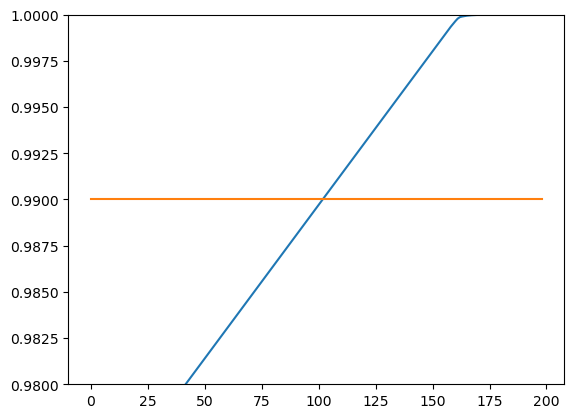

In [ ]:
plt.plot(hot_pca.explained_variance_ratio_.cumsum())
plt.plot([0.99]*199)
plt.ylim(0.98, 1)

--> take 100 components

In [ ]:
X_train_hot_pca_lim = X_train_hot_pca.iloc[:,:100]
X_valid_hot_pca_lim = X_valid_hot_pca.iloc[:,:100]
X_train_hot_pca_lim.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca90,pca91,pca92,pca93,pca94,pca95,pca96,pca97,pca98,pca99
4360,-1.529727,0.862451,1.973352,2.518253,0.079970,1.104029,-1.373544,0.127858,-0.407081,0.316137,...,-0.055207,-0.075471,-0.046859,-0.034716,-0.199963,-0.043629,-0.010957,-0.210722,-0.047144,-0.060670
5152,3.322620,0.951410,-0.038562,1.211774,-3.234055,0.106525,-0.134617,1.674887,0.359087,-0.344605,...,-0.023734,-0.053260,0.069400,0.103398,0.167570,-0.077038,0.016340,0.057536,0.110123,-0.065047
2073,1.073962,-0.640477,-2.785395,-1.089317,-0.958354,-0.139006,-1.112987,-0.947105,0.350526,-0.388615,...,-0.053721,0.053868,-0.139312,-0.015625,-0.046239,0.013164,0.110485,0.039668,0.071191,0.051733
4269,-1.066756,0.045669,0.493086,-1.445353,0.574824,-0.817825,-1.004938,0.147405,0.249213,-0.783239,...,0.007306,-0.048965,-0.009906,0.001059,0.004475,0.063187,0.048094,-0.039300,-0.016775,-0.006282
5096,1.509648,1.065530,2.800243,1.717262,2.921624,-0.119885,-0.293201,-1.424427,0.083685,-1.265936,...,-0.129826,-0.050482,0.016165,0.009660,-0.013444,-0.059546,0.001005,-0.114037,0.117905,0.068433


In [ ]:
Y_train.columns

Index(['gdp_per_capita', 'water_stress',
       'total_population_with_access_to_safe_drinking_water'],
      dtype='object')

In [ ]:
def print_model_performance(ytrain, ytrainp, ytest, ytestp):
    print("train")
    print("MAE: ", round(mean_absolute_error(ytrain, ytrainp), 3))
    print("R2:  ", round(r2_score(ytrain, ytrainp), 3))
    print("")
    print("test")
    print("MAE: ", round(mean_absolute_error(ytest, ytestp), 3))
    print("R2:  ", round(r2_score(ytest, ytestp), 3))

    fig, axs = plt.subplots(1,2, figsize=(5, 2))
    
    axs[0].plot(ytrain, ytrainp, 'o')
    axs[0].set_ylabel('y-train-p')
    axs[0].set_xlabel('y-train')
    min_0 = min([min(ytrain), min(ytrainp)]) 
    max_0 = max([max(ytrain), max(ytrainp)])
    axs[0].plot(np.arange(min_0, max_0, 0.1), np.arange(min_0, max_0, 0.1), 'r--', lw=0.5, alpha=0.5)

    axs[1].plot(ytest, ytestp, 'o')
    axs[1].set_ylabel('y-valid-p')
    axs[1].set_xlabel('y-valid')
    min_1 = min([min(ytest), min(ytestp)]) 
    max_1 = max([max(ytest), max(ytestp)])
    axs[1].plot(np.arange(min_1, max_1, 0.1), np.arange(min_1, max_1, 0.1), 'r--', lw=0.5, alpha=0.5)

    fig.tight_layout()

save drinking water

In [ ]:
xgb_model_save = XGBRegressor()

xgb_model_save.fit(X_train_hot_pca_lim, Y_train["total_population_with_access_to_safe_drinking_water"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
y_train_p = xgb_model_save.predict(X_train_hot_pca_lim)
y_val_p = xgb_model_save.predict(X_valid_hot_pca_lim)

train
MAE:  0.07
R2:   1.0

test
MAE:  0.737
R2:   0.99


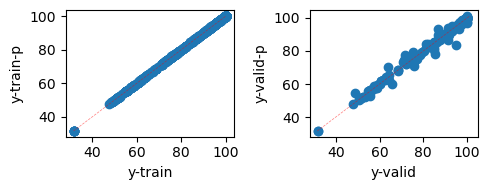

In [ ]:
print_model_performance(Y_train["total_population_with_access_to_safe_drinking_water"], y_train_p, Y_valid["total_population_with_access_to_safe_drinking_water"], y_val_p)

In [ ]:
Y_train["total_population_with_access_to_safe_drinking_water"].describe()


count    1139.000000
mean       87.295435
std        15.316385
min        31.700000
25%        77.900000
50%        93.800000
75%        99.500000
max       100.000000
Name: total_population_with_access_to_safe_drinking_water, dtype: float64

GDP

train
MAE:  107.538
R2:   1.0

test
MAE:  1082.521
R2:   0.983


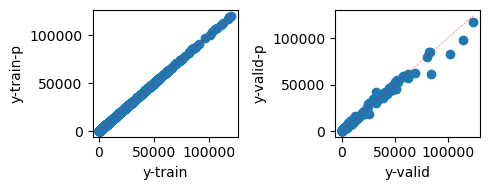

In [ ]:
xgb_model_gdp = XGBRegressor()

xgb_model_gdp.fit(X_train_hot_pca_lim, Y_train["gdp_per_capita"])
y_train_p = xgb_model_gdp.predict(X_train_hot_pca_lim)
y_val_p = xgb_model_gdp.predict(X_valid_hot_pca_lim)
print_model_performance(Y_train["gdp_per_capita"], y_train_p, Y_valid["gdp_per_capita"], y_val_p)

In [ ]:
Y_train["gdp_per_capita"].describe()

count      1139.000000
mean      13766.969999
std       19828.122939
min         105.440171
25%        1464.572242
50%        5094.384038
75%       16506.780464
max      120142.923763
Name: gdp_per_capita, dtype: float64

water stress

train
MAE:  0.195
R2:   1.0

test
MAE:  1.609
R2:   1.0


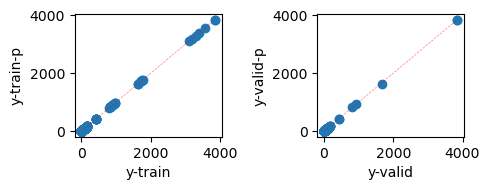

In [ ]:
xgb_model_stress = XGBRegressor()

xgb_model_stress.fit(X_train_hot_pca_lim.drop(1901), Y_train["water_stress"].drop(1901))
y_train_p = xgb_model_stress.predict(X_train_hot_pca_lim.drop(1901))
y_val_p = xgb_model_stress.predict(X_valid_hot_pca_lim)
print_model_performance(Y_train["water_stress"].drop(1901), y_train_p, Y_valid["water_stress"], y_val_p)

In [ ]:
Y_train["water_stress"].describe()

count    1138.000000
mean       71.650778
std       315.772060
min         0.027446
25%         3.839188
50%        11.261506
75%        39.553314
max      3850.500000
Name: water_stress, dtype: float64

In [ ]:
Y_train[Y_train["water_stress"].isna()]

,gdp_per_capita,water_stress,total_population_with_access_to_safe_drinking_water
1901,9229.833788,NaN,97.3


In [ ]:
Y_train.drop(1901).isna().sum()

gdp_per_capita                                         0
water_stress                                           0
total_population_with_access_to_safe_drinking_water    0
dtype: int64

### using no country information

PCA

In [ ]:
pca = PCA()

X_train_pre_pca = pca.fit_transform(X_train_pre.drop(columns=["country", "year"]))
X_valid_pre_pca = pca.transform(X_valid_pre.drop(columns=["country", "year"], axis=1))
print(X_train_pre_pca.shape)
print(X_valid_pre_pca.shape)
print("NaNs in train: ", X_train_pre_pca.isna().sum().sum())
print("NaNs in valid: ", X_valid_pre_pca.isna().sum().sum())

(1139, 36)
(245, 36)
NaNs in train:  0
NaNs in valid:  0


(15.0, 25.0)

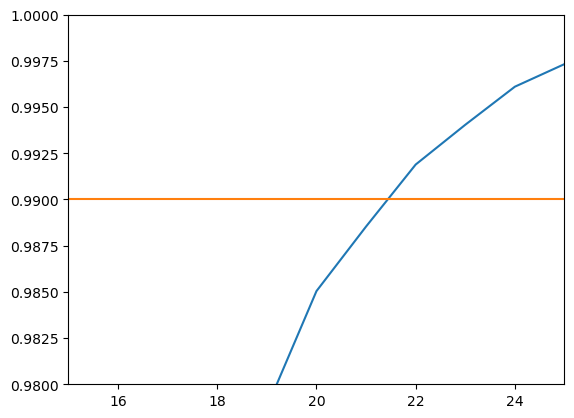

In [ ]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.plot([0.99]*199)
plt.ylim(0.98, 1)
plt.xlim(15,25)

--> take 23 components

In [ ]:
X_train_pre_pca_lim = X_train_pre_pca.iloc[:,:23]
X_valid_pre_pca_lim = X_valid_pre_pca.iloc[:,:23]
X_train_pre_pca_lim.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22
4360,-1.529212,0.862001,1.971373,2.515192,0.079972,1.101795,-1.370206,0.126895,-0.405839,0.313820,...,-0.877659,-0.051657,0.150712,0.949447,-0.608297,-0.305351,-0.111042,0.098861,0.290884,0.408484
5152,3.321541,0.950912,-0.038363,1.210454,-3.229648,0.105593,-0.135355,1.671353,0.357809,-0.342709,...,-0.460782,-0.108212,-0.022718,0.176111,-0.135341,-0.088800,1.063952,-0.119136,0.148327,-0.375265
2073,1.073587,-0.640190,-2.782743,-1.087844,-0.957095,-0.138003,-1.110343,-0.945685,0.349812,-0.387481,...,-0.817534,0.362948,-0.868757,-0.047031,0.326308,0.411295,0.074980,0.259133,0.198803,-0.406923
4269,-1.066320,0.045521,0.492583,-1.443870,0.574181,-0.816247,-1.002412,0.145672,0.249206,-0.783018,...,-0.419583,-0.129073,0.378632,-0.564411,-0.096978,-0.700897,-0.240810,-0.027662,-0.342543,-0.580911
5096,1.509153,1.064965,2.797784,1.715264,2.917775,-0.119435,-0.291024,-1.420955,0.084376,-1.255765,...,1.588464,0.934671,-0.643929,0.764737,0.928257,-0.652354,0.378801,-0.675544,0.101343,-0.220127


save drinking water

train
MAE:  0.065
R2:   1.0

test
MAE:  0.802
R2:   0.991


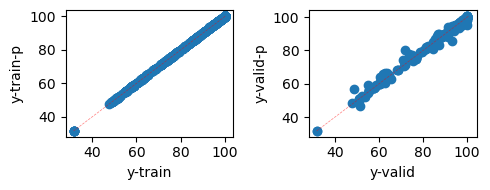

In [ ]:
xgb_model = XGBRegressor()

xgb_model.fit(X_train_pre_pca_lim, Y_train["total_population_with_access_to_safe_drinking_water"])
y_train_p = xgb_model.predict(X_train_pre_pca_lim)
y_val_p = xgb_model.predict(X_valid_pre_pca_lim)
print_model_performance(Y_train["total_population_with_access_to_safe_drinking_water"], y_train_p, Y_valid["total_population_with_access_to_safe_drinking_water"], y_val_p)


In [ ]:
Y_train["total_population_with_access_to_safe_drinking_water"].describe()

count    1139.000000
mean       87.295435
std        15.316385
min        31.700000
25%        77.900000
50%        93.800000
75%        99.500000
max       100.000000
Name: total_population_with_access_to_safe_drinking_water, dtype: float64

GDP

train
MAE:  89.122
R2:   1.0

test
MAE:  1155.556
R2:   0.984


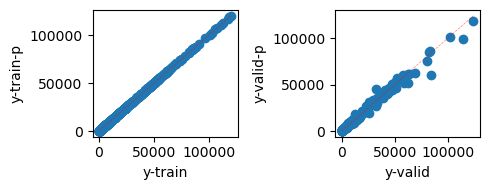

In [ ]:
xgb_model = XGBRegressor()

xgb_model.fit(X_train_pre_pca_lim, Y_train["gdp_per_capita"])
y_train_p = xgb_model.predict(X_train_pre_pca_lim)
y_val_p = xgb_model.predict(X_valid_pre_pca_lim)
print_model_performance(Y_train["gdp_per_capita"], y_train_p, Y_valid["gdp_per_capita"], y_val_p)

In [ ]:
Y_train["gdp_per_capita"].describe()

count      1139.000000
mean      13766.969999
std       19828.122939
min         105.440171
25%        1464.572242
50%        5094.384038
75%       16506.780464
max      120142.923763
Name: gdp_per_capita, dtype: float64

water stress

train
MAE:  0.149
R2:   1.0

test
MAE:  3.839
R2:   0.993


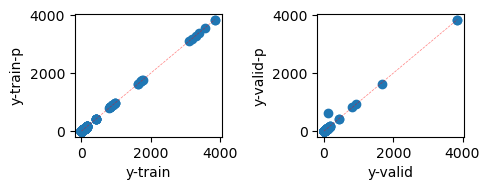

In [ ]:
xgb_model = XGBRegressor()

xgb_model.fit(X_train_pre_pca_lim.drop(1901), Y_train["water_stress"].drop(1901))
y_train_p = xgb_model.predict(X_train_pre_pca_lim.drop(1901))
y_val_p = xgb_model.predict(X_valid_pre_pca_lim)
print_model_performance(Y_train["water_stress"].drop(1901), y_train_p, Y_valid["water_stress"], y_val_p)

In [ ]:
Y_train["water_stress"].describe()

count    1138.000000
mean       71.650778
std       315.772060
min         0.027446
25%         3.839188
50%        11.261506
75%        39.553314
max      3850.500000
Name: water_stress, dtype: float64

best result with default hyper parameters so far:  
hot encoded countries,  
exclude year 

now lets run a grid search on this

In [ ]:
from sklearn.model_selection import GridSearchCV

save drinking water

In [ ]:
# Define your hyperparameters for GridSearchCV
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
}

In [ ]:
# gs1 = GridSearchCV(XGBRegressor(), params, cv=3, n_jobs=-1) # scoring is r2_score
# gs1.fit(X_train_hot_pca_lim, Y_train["total_population_with_access_to_safe_drinking_water"])

# besti = gs1.best_estimator_
# y_train_p = besti.predict(X_train_hot_pca_lim)
# y_val_p = besti.predict(X_valid_hot_pca_lim)
# print_model_performance(Y_train["total_population_with_access_to_safe_drinking_water"], y_train_p, Y_valid["total_population_with_access_to_safe_drinking_water"], y_val_p)
# print(gs1.best_params_)

GDP

In [ ]:
# gs2 = GridSearchCV(XGBRegressor(), params, cv=3, n_jobs=-1) # scoring is r2_score
# gs2.fit(X_train_hot_pca_lim, Y_train["gdp_per_capita"])

# besti = gs2.best_estimator_
# y_train_p = besti.predict(X_train_hot_pca_lim)
# y_val_p = besti.predict(X_valid_hot_pca_lim)
# print_model_performance(Y_train["gdp_per_capita"], y_train_p, Y_valid["gdp_per_capita"], y_val_p)
# print(gs2.best_params_)

water stress

In [ ]:
# gs3 = GridSearchCV(XGBRegressor(), params, cv=3, n_jobs=-1) # scoring is r2_score
# gs3.fit(X_train_hot_pca_lim.drop(1901), Y_train["water_stress"].drop(1901))

# besti = gs3.best_estimator_
# y_train_p = besti.predict(X_train_hot_pca_lim.drop(1901))
# y_val_p = besti.predict(X_valid_hot_pca_lim)
# print_model_performance(Y_train["water_stress"].drop(1901), y_train_p, Y_valid["water_stress"], y_val_p)
# print(gs3.best_params_)

In [ ]:
ps1 = {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
ps2 = {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5}
ps3 = {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}

# update spcific search grids! by comparing to:
params1 = {
}
params2 = {
    'n_estimators': [2000],
}
params3 = {
}

total_population_with_access_to_safe_drinking_water


train
MAE:  0.003
R2:   1.0

test
MAE:  0.502
R2:   0.996
{}

gdp_per_capita
train
MAE:  3.884
R2:   1.0

test
MAE:  990.509
R2:   0.99
{'n_estimators': 2000}

water_stress
train
MAE:  0.283
R2:   1.0

test
MAE:  2.319
R2:   0.999
{}


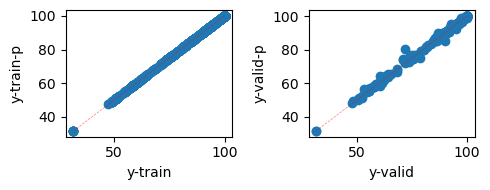

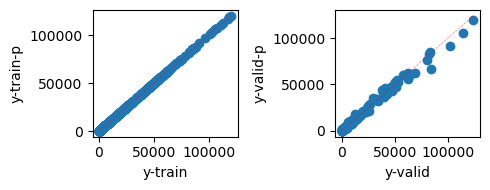

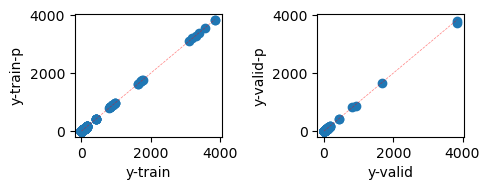

In [ ]:
print("total_population_with_access_to_safe_drinking_water")
gs11 = GridSearchCV(XGBRegressor(learning_rate=0.1, max_depth=5, subsample=1., colsample_bytree=.3, n_estimators=1500), params1, cv=3, n_jobs=-1) # scoring is r2_score
gs11.fit(X_train_hot_pca_lim, Y_train["total_population_with_access_to_safe_drinking_water"])

besti = gs11.best_estimator_
y_train_p = besti.predict(X_train_hot_pca_lim)
y_val_p = besti.predict(X_valid_hot_pca_lim)
print_model_performance(Y_train["total_population_with_access_to_safe_drinking_water"], y_train_p, Y_valid["total_population_with_access_to_safe_drinking_water"], y_val_p)
print(gs11.best_params_)

print("")
print("gdp_per_capita")
gs22 = GridSearchCV(XGBRegressor(learning_rate=0.1, max_depth=5, subsample=.5, colsample_bytree=.5), params2, cv=3, n_jobs=-1) # scoring is r2_score
gs22.fit(X_train_hot_pca_lim, Y_train["gdp_per_capita"])

besti = gs22.best_estimator_
y_train_p = besti.predict(X_train_hot_pca_lim)
y_val_p = besti.predict(X_valid_hot_pca_lim)
print_model_performance(Y_train["gdp_per_capita"], y_train_p, Y_valid["gdp_per_capita"], y_val_p)
print(gs22.best_params_)

print("")
print("water_stress")
gs33 = GridSearchCV(XGBRegressor(learning_rate=0.1, max_depth=3, subsample=1., colsample_bytree=.5, n_estimators=1000), params3, cv=3, n_jobs=-1) # scoring is r2_score
gs33.fit(X_train_hot_pca_lim.drop(1901), Y_train["water_stress"].drop(1901))

besti = gs33.best_estimator_
y_train_p = besti.predict(X_train_hot_pca_lim.drop(1901))
y_val_p = besti.predict(X_valid_hot_pca_lim)
print_model_performance(Y_train["water_stress"].drop(1901), y_train_p, Y_valid["water_stress"], y_val_p)
print(gs33.best_params_)

In [ ]:
final_models = {
    "sdw": Pipeline([("preprocess", hot_preprocessor), ("col_drop", ColumnDropper(["num__year"])), ("pca", hot_pca), ("col_slice", ColumnSlicer([[0, None], [0, 100]])), ("estimate", gs11.best_estimator_)]),
    "gdp": Pipeline([("preprocess", hot_preprocessor), ("col_drop", ColumnDropper(["num__year"])), ("pca", hot_pca), ("col_slice", ColumnSlicer([[0, None], [0, 100]])), ("estimate", gs22.best_estimator_)]),
    "ws": Pipeline([("preprocess", hot_preprocessor), ("col_drop", ColumnDropper(["num__year"])), ("pca", hot_pca), ("col_slice", ColumnSlicer([[0, None], [0, 100]])), ("estimate", gs33.best_estimator_)])
}

In [ ]:
df_pre_2020.query("country == 'Angola'")

,country,year,%_of_agricultural_gva_produced_by_irrigated_agriculture,%_of_agricultural_water_managed_area_equipped_for_irrigation,%_of_total_country_area_cultivated,agricultural_water_withdrawal,agricultural_water_withdrawal_as_%_of_total_renewable_water_resources,agricultural_water_withdrawal_as_%_of_total_water_withdrawal,agriculture_value_added_%_gdp,cultivated_area_arable_land_plus_permanent_crops,...,total_dam_capacity,total_internal_renewable_water_resources,total_internal_renewable_water_resources_per_capita,total_population,total_renewable_groundwater,total_renewable_water_resources_per_capita,total_water_withdrawal,total_water_withdrawal_per_capita,urban_population,water_resources_total_external_renewable
227,Angola,2020,0.466535,21.090918,4.183043,0.1467,0.098854,20.784925,9.429773,5215.0,...,9.44521,148.0,4503.09667,32866.272,58.0,4515.267202,0.7058,21.474903,21936.953,0.4


In [ ]:
final_models["sdw"].predict(df_pre_2020.query("country == 'Angola'"))

array([49.00204], dtype=float32)

In [ ]:
with open("model.pkl", "wb") as file:
    pkl.dump(final_models, file)

In [73]:
len(y_train_p)

1138

sdw
train
MAE:  0.005
R2:   1.0

test
MAE:  0.603
R2:   0.991
====####====
gdp
train
MAE:  11.479
R2:   1.0

test
MAE:  876.325
R2:   0.993
====####====
ws
train
MAE:  0.321
R2:   1.0

test
MAE:  2.235
R2:   0.998
====####====


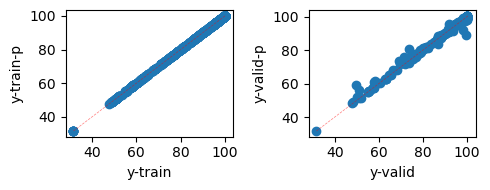

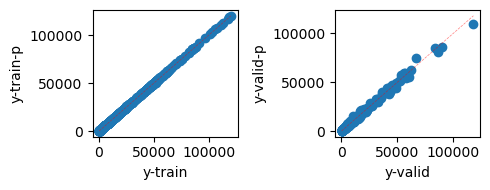

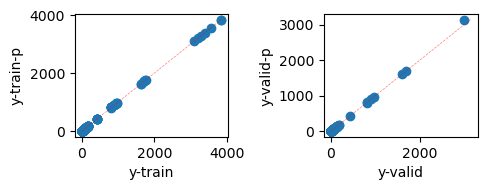

In [78]:
key_dict = {"sdw": "total_population_with_access_to_safe_drinking_water", "gdp": "gdp_per_capita", "ws": "water_stress" }
for k, m in final_models.items():
    print(k)
    y_pred = m.predict(X_test)
    # print(y_pred)
    # print(Y_test[key_dict[k]])
    if k=="ws":
        y_train_p = m.predict(X_train.drop(1901))
        print_model_performance(Y_train[key_dict[k]].drop(1901), y_train_p, Y_test[key_dict[k]], y_pred)
    else: 
        y_train_p = m.predict(X_train)
        print_model_performance(Y_train[key_dict[k]], y_train_p, Y_test[key_dict[k]], y_pred)
    print("====####====")

    

end